# Tree based models

So far we discussed baseline models which all consist of an algorithm with a linear predictor function in combination with a transformation suited to the learning problem. The function depends on a set of parameters which is estimated with training data. 

Nowadays, a great variety of different models exists which provides a broad range of model flexibility. While it is not our aim to discuss all these models, I want to discuss two different model types in this and the next section: (1) tree based models and (2) neural networks. Both types perform very well for a broad range of learning problems and it is worth discussing them both in detail, because their architecture differs but each approach is interesting on their own. 

The name tree based models already reveals their architecture. They can be used for regression and classification problem and the main idea is to split the predictor space such that for each subspace, predictions are made which lead to an overall good performance for the whole data set.

## Regression Trees

Take a look in the figure below which exhibits in the left plot a relationship between two features $\boldsymbol{X}_1$ and $\boldsymbol{X}_2$. Assume each data point is related to a metric value for a target $Y_i$. In the figure, all data points are divided into three rectangles $R_1, R_2, R_3$, while each split is defined by a split point $s$. In the right plot, we can see how each region can be found. For instance, if $X_{i1} \leq -0.96$ and $X_{i2} > 0.668$, we are in region $R_3$. If we want to make predictions for the target variable, we use average observations of the targets in the rectangle. For instance if feature values for a given observation $i$ bring us to region $R_3$, the average value of $y_i \in R_3$ is used for prediction.

As you may have guessed, this idea is what is called a **regression tree**. It is called a tree because of the tree like structure which can be seen in the right plot. The structure follows split points which leads to a set of nodes and edges. Each terminal node, also called leaf, represents a certain region in the left plot. 

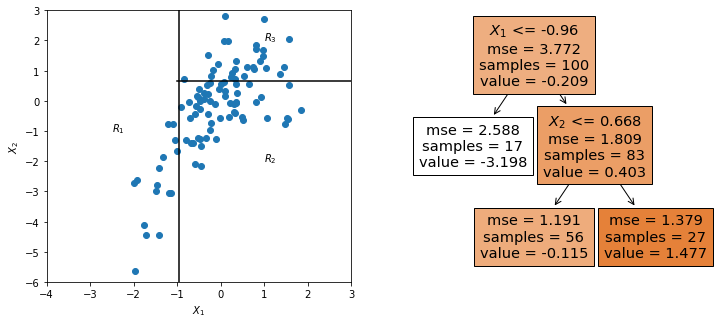

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

m = 100
np.random.seed(42)
x_1 = np.random.normal(size = m)
x_2 = 0.5 + 1.2 * x_1 - 0.9 * x_1**2 + np.random.normal(size = m)
X = np.concatenate((x_1.reshape(-1, 1), x_2.reshape(-1, 1)), axis = 1)

y = 0.2 * 1.5 * x_1 + 0.7 * x_2 + np.random.normal(size = m)

dtr = DecisionTreeRegressor(ccp_alpha = 0.25)
dtr.fit(X, y)

fig, axs = plt.subplots(nrows = 1, ncols = 2,figsize = (12,5))
axs[0].scatter(x_1, x_2)
axs[0].set_xlim([-4, 3])
axs[0].set_ylim([-6, 3])
axs[0].plot([-0.96, -0.96], [-6, 3], color = 'black')
axs[0].plot([-1, 3], [0.67, 0.67], color = 'black')
axs[0].set_xlabel(r'$X_1$')
axs[0].set_ylabel(r'$X_2$')
axs[0].text(-2.5, -1, r'$R_1$')
axs[0].text(1, -2, r'$R_2$')
axs[0].text(1, 2, r'$R_3$')

tree.plot_tree(dtr, filled = True, feature_names = [r'$X_1$', r'$X_2$'])
plt.show()

Okay, but how do we derive a regression tree? As before, building a regression tree consists of finding an algorithm which provides estimates for the target variable and appropriately adjusting this algorithm to training data such that the prediction mechanism genralizes, i.e., also leads to good model performance of training data. If the learning problem is a regression problem, we again aim to minimize squared deviations between predictions and observations. Given a number of regions $R_1, ..., R_L$, the model loss can be derived by:

$$
RSS = \sum_{l = 1}^L \sum_{i \in R_l} \left(y_i - \hat{y}_{R_l}\right)^2
$$

with 

$$
\hat{y}_{R_l} = \frac{1}{\# \lbrace y_i | y_i \in R_l  \rbrace} \sum_{i \in R_l} y_i
$$

The value of the loss function can be altered by choosing feature variable $j$ and split point $s$. As we can not analyze the loss function for all possible partitions of the feature space, so called **recursive binary splitting** is used to approach the best possible split of the data. Starting from the top of the tree, among all features $\boldsymbol{X}_1, ..., \boldsymbol{X}_n$ we are searching for the feature $j$ and the split point $s$ which reduces the $RSS$ to the highest extent. More concrete, with the choice of $(j, s)$ and $R_1(j, s) = \lbrace \boldsymbol{X} | \boldsymbol{X}_j \leq s \rbrace$ and $R_2(j, s) = \lbrace \boldsymbol{X} | \boldsymbol{X}_j > s \rbrace$:

$$
\sum_{i \in R_1(j, s)} \left(y_i - \hat{y}_{R_1} \right)^2 + \sum_{i \in R_2(j, s)} \left(y_i - \hat{y}_{R_2} \right)^2
$$

is minimized. This is how the first split is defined. After that the procedure is repeated on $R_1$ or R_2, depending for which partition the RSS can be most reduced. 

If no stopping condition is set, this procedure can be continued until the training data if perfectly predicted by the tree, because we can use as many splits as data points. This will lead to massive overfitting and high predictor variance for different data sets. Accordingly, the tree splitting process must be stopped at a certain point to avoid overfitting. Different possibilities exists for this purpose. 

1. We can reduced the maximum tree depth
2. We can set a minimum number of observations for each leaf
3. Define a minimum number of samples for splitting nodes
4. Define a minimum improvement of the loss which needs to be achieved by a split
5. Prune the tree in hindsight

While the first four possibilities hopefully explain themselves, we may need to talk about **pruning**. It picks up the idea of regularization and might be a better way for finding the best tree structure than simply cutting the tree nodes like it is done when setting a maximum tree depth or defining minimum improvements per split. Imagine a certain split does not lead to a high improvement of the model, but is necessary for finding the next split which leads to a significant improvement of the model. In order to find such trees, pruning first estimates a very large tree $T_0$ and then searches for a subtree which balances the trade-off between complexity, adjustment to training data and generalization. Setting a hyperparameter $\alpha$, a subtree $T \subset T_0$ with a lower number of terminal nodes $|T| < |T_0|$ is searched such that 

$$
\sum_{l = 1}^{|T|} \sum_{i \in R_l} \left(y_i - \hat{y}_{R_l}\right)^2 + \alpha |T|
$$

As you can see, the higher $\alpha$, the more more complex trees with a higher number of leafs are penalized. As for all models with hyperparameters, values are searched by splitting the data into, training, validation and test data. Only model which lead to comparably good results for training and validation data should be chosen and finally evaluated on test data. To get a better feeling for growing regression trees, let us take a look at a few examples. For a simulated data set, a full regression tree without stopping criteria looks like this:

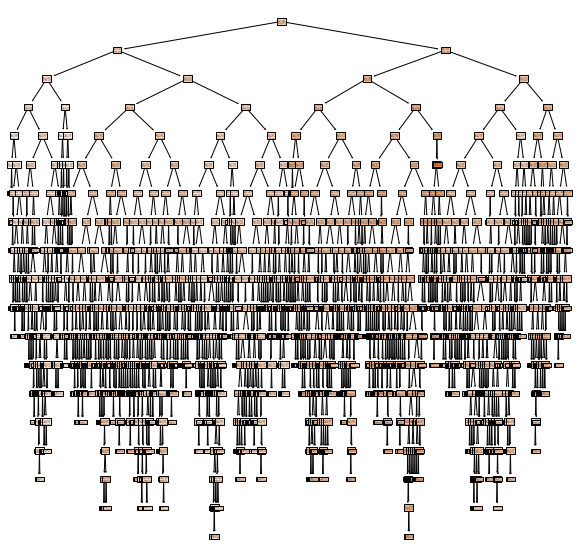

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pylab as plt

#sample size of 1,000 data points
m = 1000

#parameter values
w = np.array([1.2, -0.7, 0.2])
b = 0.5

#randomly generate feature values for three feature variables 
np.random.seed(42)
X = np.random.normal(size = 3 * m).reshape(m, 3)

#generate metric target variable
y = X.dot(w) + b + np.random.normal(size = m, scale = 0.3)

#if we do not set any barriers during estimatin, the tree fits the training data perfectly
#this leads to overfitting
dtr = DecisionTreeRegressor()

#fit the tree
dtr.fit(X, y)

#visualize the tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10))
tree.plot_tree(dtr, filled = True)
plt.show()

If we set the tree depth to two, a very simple version of it results.

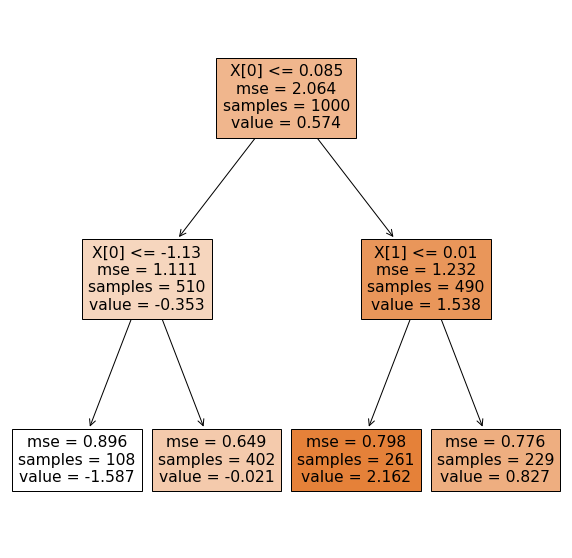

In [3]:
#define a decision tree for regression
#for better visibility, we first fit a tree with a fixed depth of two
dtr = DecisionTreeRegressor(max_depth = 2)

#fit the tree
dtr.fit(X, y)

#visualize the tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10))
tree.plot_tree(dtr, filled = True)
plt.show()

Fixing the number of minimum samples per leaf strongly depends on the number of observations in the training data and model complexity. In our example, data contains 1,000 observations. Setting the minimum number per leaf to 100, results in a tree as can be seen here.

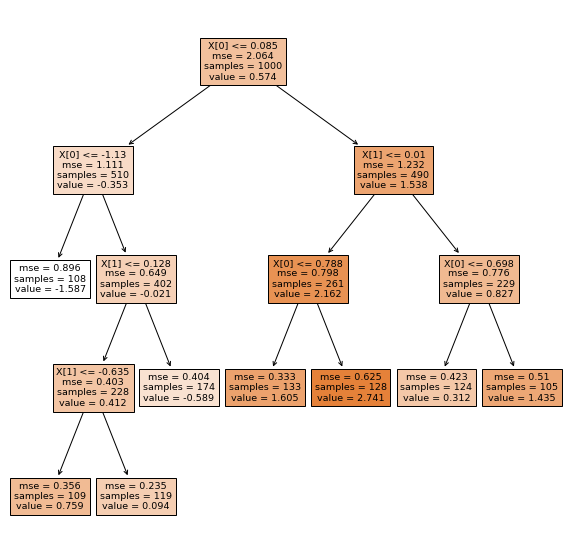

In [4]:
#we may stop splitting nodes if the number per node are below a minimum value
dtr = DecisionTreeRegressor(min_samples_leaf = 100)

#fit the tree
dtr.fit(X, y)

#visualize the tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10))
tree.plot_tree(dtr, filled = True)
plt.show()

Another alternative is given by pruning the tree which is controlled by setting $\alpha$. Reasonable ranges for $\alpha$ also depend on the data and need to be tested anyway when optimizing the hyperparameter. For instance, a value $\alpha = 0.05$ results in the following structure.

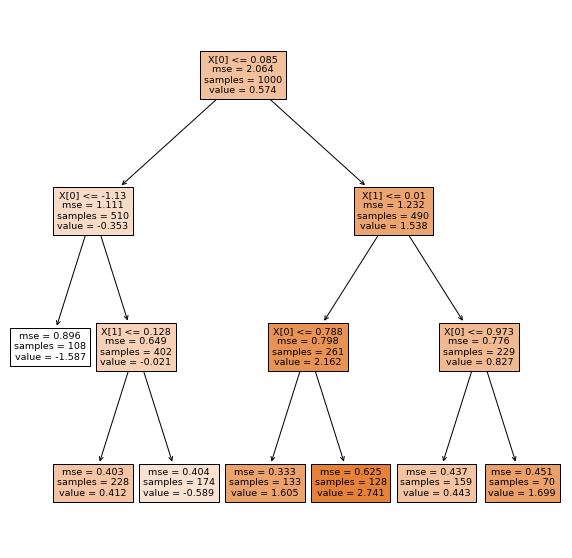

In [5]:
#we may use of tree pruning which is controlled by ccp_alpha
dtr = DecisionTreeRegressor(ccp_alpha = 0.05)

#fit the tree
dtr.fit(X, y)

path = dtr.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#visualize the tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10))
tree.plot_tree(dtr, filled = True)
plt.show()

## Decision Trees

So far, we examined a regression problem. How do we derive trees for classification problems? More or less in the same manner, however, we can not use $RSS$ to evaluate model performance. Instead, we need a loss function which is suited for the classification problem. Intuitively, we may want to minimize the classification error. However, it has been found that this does not lead to qualitative tree structures. Instead, at each split either the **Gini index** or **cross-entropy** is used to evaluate the quality of the split. The Gini index $G$ is given by:

$$
G = \sum_k \hat{p}_{lk} (1 - \hat{p}_{lk})
$$

and cross-entropy $H$ is defined by:

$$
H = - \sum_k \hat{p}_{lk} \log \hat{p}_{lk}
$$

$\hat{p}_{lk}$ represents the fraction of training observations from class $k$ in the region $l$. So basically, we are making a frequency-based probability prediction for $P(Y_i = k)$ which is based on the degree of categorical dominance in a certain region $l$. Both $G$ and $H$ are return lower values for regions which are characterized by high categorical class dominance. Intuitively, this means splits are preferable which result in leafs that contain observations from the same category. Also note that minimizing cross-entropy is directly related to likelihood maximization.

## Feature importance for Trees

Trees are popular because it can be visualized and easily understood how predictions are generated. This already gives a first impression which of the features are most important, because the ones which are chosen first, are the ones which reduce the loss objective the most and, thus, are most important for predicting the target. To quantify feature importance, we may derive the relative reduction of the overall loss objective, e.g., $RSS$ for regression trees and the $G$ for decision trees, for each feature.  

## Bagging, Random Forests and Boosting

In general, an important technique for machine learning algorithms is given by **ensemble learning**. This approach uses the wisdom of the crowd by averaging predictions of various prediction models. Intuitively, while some predictions maybe too low, others will be too high which on average leads to accurate predictions. Statistically, the great advantage of ensemble learning lies in estimator variance reduction which is of special relevance for tree based methods. 

Remember, that if not limited by an adequate hyperparameter choice, trees can be adjusted perfectly to training data  which leads to overfitting in addition with high variance of estimated predictors for different data sets. High variance is disadvantageous, because it may lead to very high deviations from adequate predictions for certain data sets. Also remember, that for $m$ independent random variables $X_1, ..., X_m$ with variance $\sigma_{X_i}^2$, the estimator $\bar{X} = \frac{1}{n} \sum_i X_i$ has only a variance of $\sigma_{\bar{X}} = \frac{\sigma_{X_i}^2}{m}$. Accordingly, the idea of ensemble learning is to generate a certain number of different prediction models and average over these predictions to generate final predictions with low variance.

This concept is applicable for different algorithms, but very useful for regression and decision trees. But how do we generate different predictors, i.e., different algorithms? We sample a subset $b$ of the data, which is not identical to the overall data set, and fit a tree which is denoted by $\hat{f}^b$, where $b$ stands for the $b$ bootstrapped sample of the overall data set. Note that sample size of the bootstrapped sample does not necessarily be smaller than the original data set, because we can draw individual samples with replacement. This will lead to sampled data sets which may contain duplicated observations and will not contain a certain number of observations from the original data set. After sampling $B$ data sets, we have grown $f^1, ..., f^B$ trees which can be used to generate $B$ predictions $\hat{f}^b (\boldsymbol{x}_i), ..., \hat{f}^B(\boldsymbol{x}_i)$ for an observation $\boldsymbol{x}_i$. Finally, the prediction which we use is given by averaging, i.e., 

$$
\hat{y}_i = \frac{1}{B} \sum_b \hat{f}^b (\boldsymbol{x}_i)
$$

If our goal is to provide a categorical prediction, we can use a majority vote over all bootstrapped predictions, i.e., the category which is predicted the most over all samples $B$.

If we proceed like this, we make use of **bagging**. Bagging might run into problems if trees for different data samples are too similar. This will lead to highly correlated trees such that variance reduction is diminished. The reason for high correlation could lie in feature importance, e.g., one feature might be very important and is selected always first in the tree. To reduce this potential disadvantage a technique called **random forest** is chosen. Random forests are constructed exactly as the bagging approach with the exception that only a subset of features is used for each tree. A typical choice is to use $\sqrt{n}$ features for each single tree. By this means, trees are less correlated which increases variance reduction among predictors.

As a certain number of observations is not used for training for each bootstrapped sample, these observations can be used for testing the model. If observation $i$ is not used for training, we can make a prediction and record it. To generate a prediction for this observation, all predictions from samples which did not use this observation for training are averaged (for regression problems) or selected according to a majority vote (for classification problems). By this way out of sample predictions are generated and out of sample performance can be evaluated.

For bagging as well as for random forests each tree is fully grown for the sampled data set. Another approach which also belongs to ensemble learning is **boosting**. Boosting does not fully grow a tree for one data sample and then continues with the next sample, its technique makes use of an iterative approach among trees. As the illustration of the concrete approach is different in its nature from bagging and random forests, its illustration is beyond the scope of this book, which is  why we skip its illustration.

Unfortunately, the presented methods in this subsection loose their intuitive interpretability in comparison to single tree models. Nevertheless, feature importance can be derived in a similar manner as described before. For each tree, the reduction in the loss objective is recorded for each feature and averaged over each bootstrapped sample. 

Finally, we provide three code snippets which demonstrate the use of bagging, random forests and boosting for a categorical prediction problem with two classes.

In [6]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pylab as plt

##################################
#Bagging       
##################################


#sample size of 1,000 data points
m = 1000

#parameter values
w = np.array([1.2, -0.7, 0.2])
b = 0.5

#randomly generate feature values for three feature variables 
np.random.seed(42)
X = np.random.normal(size = 3 * m).reshape(m, 3)

#now we generate values for the probabilities of P(Y_i = 1) 
z = X.dot(w) + b 
pi = 1 / (1 + np.exp(-z))

#draw random Bernoulli numbers according to these probabilities
y = np.random.binomial(n = 1, p = pi)

#define a bagging model
bagging_model = BaggingClassifier(base_estimator = DecisionTreeClassifier(),
                                 n_estimators = 100,
                                 max_samples = 1.0, 
                                 oob_score = True)

#fit the model
bagging_model.fit(X, y)

#out of bag performance
print(f'Predictive accuracy for out of sample predictions: {bagging_model.oob_score_:.4f}')

#determine which feature is most important
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_model.estimators_
], axis=0)

for i, feat in enumerate(feature_importances):
    print(f'Relative importance of feature {i+1} in %: {feat*100:2.2f}')

Predictive accuracy for out of sample predictions: 0.7110
Relative importance of feature 1 in %: 42.65
Relative importance of feature 2 in %: 35.55
Relative importance of feature 3 in %: 21.80


In [7]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pylab as plt

##################################
#Random Forest       
##################################


#sample size of 1,000 data points
m = 1000

#parameter values
w = np.array([1.2, -0.7, 0.2])
b = 0.5

#randomly generate feature values for three feature variables 
np.random.seed(42)
X = np.random.normal(size = 3 * m).reshape(m, 3)

#now we generate values for the probabilities of P(Y_i = 1) 
z = X.dot(w) + b 
pi = 1 / (1 + np.exp(-z))

#draw random Bernoulli numbers according to these probabilities
y = np.random.binomial(n = 1, p = pi)

#define the random forest, for each tree, we only use two features: max_features = 2
random_forest = RandomForestClassifier(n_estimators = 100,
                                       max_features = 2,
                                       oob_score = True)

#fit the model
random_forest.fit(X, y)

#out of bag performance
print(f'Predictive accuracy for out of sample predictions: {random_forest.oob_score_:.4f}')

#determine which feature is most important
feature_importances = np.mean([
    tree.feature_importances_ for tree in random_forest.estimators_
], axis=0)

for i, feat in enumerate(feature_importances):
    print(f'Relative importance of feature {i+1} in %: {feat*100:2.2f}')

Predictive accuracy for out of sample predictions: 0.7100
Relative importance of feature 1 in %: 42.63
Relative importance of feature 2 in %: 35.34
Relative importance of feature 3 in %: 22.03


In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pylab as plt


##################################
#Boosting       
##################################


#sample size of 1,000 data points
m = 1000

#parameter values
w = np.array([1.2, -0.7, 0.2])
b = 0.5

#randomly generate feature values for three feature variables 
np.random.seed(42)
X = np.random.normal(size = 3 * m).reshape(m, 3)

#now we generate values for the probabilities of P(Y_i = 1) 
z = X.dot(w) + b 
pi = 1 / (1 + np.exp(-z))

#draw random Bernoulli numbers according to these probabilities
y = np.random.binomial(n = 1, p = pi)

#define the boosting model
boosting_model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2),
                                    n_estimators = 100)

#fit the model
boosting_model.fit(X,y)

#generate some test data
test_size = 300
X_test = np.random.normal(size = 3 * test_size).reshape(test_size, 3)

#now we generate values for the probabilities of P(Y_i = 1) 
z_test = X_test.dot(w) + b 
pi_test = 1 / (1 + np.exp(-z_test))

#draw random Bernoulli numbers according to these probabilities
y_test = np.random.binomial(n = 1, p = pi_test)

#determine the out of sample accuracy
oob_score = np.mean(boosting_model.predict(X_test) == y_test)

#out of bag performance
print(f'Predictive accuracy for out of sample predictions: {oob_score:.4f}')

#determine which feature is most important
feature_importances = np.mean([
    tree.feature_importances_ for tree in boosting_model.estimators_
], axis=0)

for i, feat in enumerate(feature_importances):
    print(f'Relative importance of feature {i+1} in %: {feat*100:2.2f}')

Predictive accuracy for out of sample predictions: 0.6933
Relative importance of feature 1 in %: 34.45
Relative importance of feature 2 in %: 36.60
Relative importance of feature 3 in %: 28.94
